In [ ]:
import os
import glob
import sklearn
import pandas as pd
import numpy as np
import gdal
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn import metrics 
drive.mount("/content/drive")
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
#read samples
train_file_noncrop = pd.read_csv('/content/drive/MyDrive/Copy of samples_intensity_MZ_noncropland_nw.csv',index_col=False)
train_file_noncrop=train_file_noncrop.sample(n=1000)

train_file_noncrop_water = pd.read_csv("/content/drive/MyDrive/Copy of samples_intensity_MZ_noncropland_w.csv",index_col=False)
train_file_noncrop_water =train_file_noncrop_water.sample(n=100) #10% of noncropland
train_file_noncropland = pd.concat([train_file_noncrop_water,train_file_noncrop])

train_file_crop= pd.read_csv("/content/drive/MyDrive/Copy of samples_intensity_MZ_cropland.csv", index_col=False)


df_SR= pd.concat([train_file_noncropland,train_file_crop])
df_SR= df_SR.drop(["system:index",".geo","landclass"], axis = 1);

df_SR= df_SR.fillna(0)


In [ ]:
from sklearn import preprocessing
def normalize(df):
  scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  names = df.columns
  d = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(d, columns=names)
  return scaled_df

In [ ]:


from scipy.signal import savgol_filter
def ndvi_reconstruct(df):
  for i in range(len(df)):
    for j in range(len(df.columns)-1):
       if df.iat[i,j] == 0 or  abs(df.iat[i,j-1] - df.iat[i,j]) > 4000 :
              df.iat[i,j] = ((df.iloc[i][1]+df.iloc[i][len(df.columns)-1])/2.0)
       if j == len(df.columns)-1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][0])/2.0)
       if j != 0 and j != len(df.columns) - 1:
                df.iat[i,j] = ((df.iloc[i][j-1]+df.iloc[i][j+1])/2.0)
  return df

In [ ]:
df_SR = ndvi_reconstruct(df_SR)

In [ ]:
from scipy.signal import savgol_filter
smoothed_NDVI = savgol_filter(df_SR, window_length = 3, polyorder = 2)
series1 = smoothed_NDVI.astype(float)

def find_cycles(Y):   
  row=Y
  l=0
  max=row[0]
  for l in range(24):
    if(row[l]>max):
      max=row[l]
    l=l+1
  if(max<3000):
    return 0

  max_val=0.7*max
  min_val=0.2*max
  maxima = []
  i =0
  while i<row.size:
    if(i==0):
      if(row[i]>=max_val):
        j=i+1;
        while(j!=24): #right traversal
          
          if(row[j]<=min_val):
            maxima.append(i)
            i=i+1
            break
          elif(row[j]>=max_val):
            i=j
            break
          elif(j==23):
            j=j+1
            i=i+1
          else:
            j=j+1
      else:
          i=i+1

    elif(i==23):
      if(row[i]>=max_val):
        j=i-1;
        while(j!=-1): #left traversal 
          if(row[j]<=min_val):
            maxima.append(i)
            i=i+1
            break
          elif(row[j]>=max_val):
            i=i+1
            break
          elif(j==0):
            j=j-1
            i=i+1
          else:
            j=j-1;
      else:
        i=i+1

    elif(i!=24):
      check=False
      # proceed=False
      if(row[i]>=max_val):
        j=i+1
        k=i-1
        while(j!=24): #right traversal
          if(row[j]<=min_val):
            # maxima.append(i)
            check=True
            break
          elif(row[j]>=max_val):
            # proceed=True
            i=j
            k=i-1
            j=j+1
            # break
          else:
            j=j+1;
        while(k!=-1): #left traversal
          if(row[k]<=min_val):
            # maxima.append(i)
            if(check==True):
              maxima.append(i)
              i=i+1
              break
            else:
              i=i+1
              break
          elif(row[k]>=max_val):
            if(k==0):
              i=i+1
            k=k-1
            # i=i+1
            # break
          elif k==0:
            i=i+1
            k=k-1
          else:
            k=k-1;
      else:
        i=i+1
    else:
      i=i+1
  return len(maxima)

In [ ]:
df_filter = pd.DataFrame(series1, columns = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'])

In [ ]:
df_filter.insert(24,"cycles"," ")

In [ ]:
for i in range(len(df_filter)):
  
  df_filter.cycles.iloc[i] = find_cycles(df_filter.iloc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:

class_0 = df_filter[df_filter['cycles']==0]
print(len(class_0.index))
class_1 = df_filter[df_filter['cycles']==1]
print(len(class_1.index))
class_2 = df_filter[df_filter['cycles']==2]
print(len(class_2.index))
class_3 = df_filter[df_filter['cycles']==3]
print(len(class_3.index))


26992
814
20
0
0


0     2058.000000
1     2661.500000
2     2610.250000
3     1813.625000
4     2295.812500
5     1147.906250
6     4143.953125
7     5593.476563
8     4199.738281
9     4666.369141
10    6304.684570
11    6903.342285
12    6914.671143
13    6696.335571
14    6809.167786
15    6861.583893
16    6173.791946
17    4246.895973
18    4521.947987
19    3195.473993
20    2567.736997
21    2070.368498
22    2092.684249
23    2115.000000
Name: 104, dtype: float64


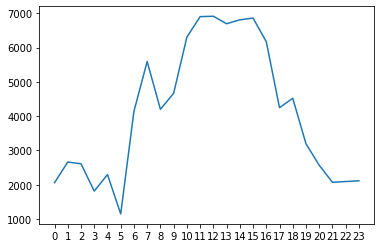

In [ ]:
class_0_plot = class_0.drop(['cycles'], axis=1)
plt.plot(class_0_plot.iloc[32])
plt.plot()
print(class_0_plot.iloc[32])

In [ ]:
class_0=class_0.sample(n=70)
class_1=class_1.sample(n=70)
class_2=class_2.sample(n=17)
class_3=class_3.sample(n=0) 

In [ ]:
dataset = pd.concat([class_0,class_1,class_2,class_3])

In [ ]:
x=dataset.drop(["cycles"], axis = 1);
y=dataset["cycles"]

In [ ]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True )
x_train=x_train.astype('int')
y_train=y_train.astype('int')
x_test=x_test.astype('int')
y_test=y_test.astype('int')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(oob_score=True, criterion='entropy',verbose=3)   
rf_clf.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

RandomForestClassifier(criterion='entropy', oob_score=True, verbose=3)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
y_pred = rf_clf.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print("Weighted f1_score= ",f1_score(y_test, y_pred,average='weighted'))
print("Weighted precision = ",precision_score(y_test, y_pred, average='weighted'))

[[18  3  0]
 [ 2 20  1]
 [ 0  0  8]]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.87      0.87      0.87        23
           2       0.89      1.00      0.94         8

    accuracy                           0.88        52
   macro avg       0.89      0.91      0.90        52
weighted avg       0.88      0.88      0.88        52

0.8846153846153846
Weighted f1_score=  0.8840083875951882
Weighted precision =  0.88482905982906


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier(objective='multi:softmax', early_stopping_rounds=10)
xgb_cl.fit(x_train,y_train,
           verbose=True)

y_pred = xgb_cl.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print("Weighted f1_score= ",f1_score(y_test, y_pred,average='weighted'))
print("Weighted precision = ",precision_score(y_test, y_pred, average='weighted'))

[[19  2  0]
 [ 0 23  0]
 [ 0  1  7]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.88      1.00      0.94        23
           2       1.00      0.88      0.93         8

    accuracy                           0.94        52
   macro avg       0.96      0.93      0.94        52
weighted avg       0.95      0.94      0.94        52

0.9423076923076923
Weighted f1_score=  0.9424712192569336
Weighted precision =  0.9489644970414202


In [ ]:
!pip install dtw
import dtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

#train
parameters = {'n_neighbors':[1]}
clf = GridSearchCV(KNeighborsClassifier(metric=DTW), parameters, cv=3, verbose=1)
clf.fit(x_train, y_train)



#evaluate
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Fitting 3 folds for each of 1 candidates, totalling 3 fits
              precision    recall  f1-score   support

           0       0.81      0.62      0.70        21
           1       0.70      0.83      0.76        23
           2       0.89      1.00      0.94         8

    accuracy                           0.77        52
   macro avg       0.80      0.82      0.80        52
weighted avg       0.78      0.77      0.76        52



In [ ]:
x=dataset.drop(["cycles"], axis = 1);
y=dataset["cycles"]
x_train=[]
y_train=[]
x_test=[]
y_test=[]
x=normalize(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True )

x_train=np.array(x_train).astype('float')
y_train=np.array(y_train).astype('float')
x_test=np.array(x_test).astype('float')
y_test=np.array(y_test).astype('float')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(105, 24)
(105,)
(52, 24)
(52,)


In [ ]:
xt=x_train
yt=y_train
xte=x_test
yte=y_test

In [ ]:
xte=xte.reshape(52,24,1)
xt=xt.reshape(105,24,1)

In [ ]:
from tensorflow.keras.utils import to_categorical
yt=to_categorical(yt,num_classes=4)
yte=to_categorical(yte,num_classes=4)
xt=xt.astype('float32')
xte=xte.astype('float32')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# Defining custom metrics to record while running
from keras import backend as K

def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv1D, MaxPool1D, Flatten, LSTM,BatchNormalization
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
model = Sequential()
model.add(Conv1D(16,3,activation='relu',
                 strides=1, padding='same',
                 input_shape=(xt.shape[1], xt.shape[2])))
model.add(Conv1D(32,3,activation='relu',
                 strides=1, padding='same'))
model.add(Conv1D(64,3,activation='relu',
                 strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(128,3,activation='relu',
                 strides=1, padding='same'))
model.add(MaxPool1D(1))
model.add(Dropout(0.5))
model.add(LSTM(128,activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(4,  activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics =['acc', F1_Score])

In [ ]:
history = model.fit(xt,yt,epochs=100, validation_split = 0.2, batch_size=32)

Epoch 1/100
3/3 [==============================] - 31s 292ms/step - loss: 1.2900 - acc: 0.4524 - F1_Score: 0.0317 - val_loss: 1.3627 - val_acc: 0.4286 - val_F1_Score: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 67ms/step - loss: 0.9211 - acc: 0.5357 - F1_Score: 0.2092 - val_loss: 1.3219 - val_acc: 0.4286 - val_F1_Score: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 70ms/step - loss: 0.7043 - acc: 0.5714 - F1_Score: 0.5619 - val_loss: 1.2845 - val_acc: 0.4286 - val_F1_Score: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 68ms/step - loss: 0.6557 - acc: 0.5952 - F1_Score: 0.5809 - val_loss: 1.2830 - val_acc: 0.4286 - val_F1_Score: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 78ms/step - loss: 0.6361 - acc: 0.7024 - F1_Score: 0.7110 - val_loss: 1.2851 - val_acc: 0.4286 - val_F1_Score: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 70ms/step - loss: 0.6417 - acc: 0.6310 - F1_Score: 0.6254 - val_

In [ ]:
# can now predict the classes
predicted_probs = model.predict(xte)

# show the class of first as we have probabilities
print(predicted_probs[0].argmax())
print(yte[0].argmax())

# appling argmax to each of the one-hot-encoded outputs
predicted = predicted_probs.argmax(axis = 1)[:,None].flatten()
actual = yte.argmax(axis = 1)[:,None].flatten()

print(predicted)
print(actual)

2/2 [==============================] - 0s 16ms/step
0
1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0]
[1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 2 0 2 0 0 0 0 0 1 2 0 1 2 0 1 0 1
 1 1 1 0 0 0 1 2 0 1 1 0 1 1 1]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.53      1.00      0.70        24
           1       0.40      0.09      0.14        23
           2       1.00      0.40      0.57         5

    accuracy                           0.54        52
   macro avg       0.64      0.50      0.47        52
weighted avg       0.52      0.54      0.44        52



In [ ]:
# !pip install -U geemap

In [ ]:
import ee
import geemap
from geemap import ml
from sklearn import ensemble
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Hj7o5cua0Y90K7tsIHl7gLdH-hjqmvBKuL_hgKlbr00&tc=IXJpRzkgYyO9SE93fp1zgIilgtdxW1NkyT7S42-ealg&cc=V4K9g8hRGS67Yu0fGR805_kfGLqPcZ9HBkNlu7GgK40

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJrxUzRemX1Zoxuw6JF0Vl_mOULiVYT-eak_OuyraGzusYoJlhnP2XQ

Successfully saved authorization token.


In [ ]:
feature_names = ['nd_p100','nd_p100_1','nd_p100_2','nd_p100_3','nd_p100_4','nd_p100_5','nd_p100_6','nd_p100_7','nd_p100_8','nd_p100_9','nd_p100_10','nd_p100_11','nd_p100_12','nd_p100_13','nd_p100_14','nd_p100_15','nd_p100_16','nd_p100_17','nd_p100_18','nd_p100_19','nd_p100_20','nd_p100_21','nd_p100_22','nd_p100_23']
label = "cycles"

In [ ]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
trees = ml.rf_to_strings(rf_clf, feature_names)
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [ ]:
l8 = ee.Image('projects/ee-g00085636/assets/NDVI_MZ_unmasked') #the unmasked image from google earth engine (I converted it into a google earth engine asset first)

In [ ]:
# classify the image using the classifier we created from the local training
# note: here we select the feature_names from the image that way the classifier knows which bands to use
classified = l8.select(feature_names).classify(ee_classifier)


In [ ]:
# display results
Map = geemap.Map(center=(18.6657, 35.5296),zoom=11)

Map.addLayer(
    l8,
    {"bands": ['nd_p100_2','nd_p100_5','nd_p100_7'], "min": -10000, "max": 10000, "gamma": 1.5},
    'image',
)
Map.addLayer(
    classified,
    { "palette": ['#ffffff', '#008000', '#ffff00','#ff0000']},
    'classification',
)
Map

Map(center=[18.6657, 35.5296], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

In [ ]:
x_train_lstm = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test_lstm = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

In [ ]:
from keras.metrics.metrics import accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout



In [ ]:
from keras.layers import Bidirectional, Activation

model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True),
                             input_shape=(24, 1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='mse',
optimizer='adam',
metrics=['accuracy'])

In [ ]:
hist = model.fit(x_train_lstm, y_train, epochs = 100)

Epoch 1/100
583/583 [==============================] - 34s 44ms/step - loss: 0.0324 - accuracy: 0.9649
Epoch 2/100
583/583 [==============================] - 26s 44ms/step - loss: 0.0288 - accuracy: 0.9679
Epoch 3/100
583/583 [==============================] - 25s 44ms/step - loss: 0.0282 - accuracy: 0.9686
Epoch 4/100
583/583 [==============================] - 28s 47ms/step - loss: 0.0280 - accuracy: 0.9682
Epoch 5/100
583/583 [==============================] - 25s 43ms/step - loss: 0.0277 - accuracy: 0.9687
Epoch 6/100
583/583 [==============================] - 25s 43ms/step - loss: 0.0275 - accuracy: 0.9692
Epoch 7/100
583/583 [==============================] - 25s 43ms/step - loss: 0.0274 - accuracy: 0.9692
Epoch 8/100
583/583 [==============================] - 25s 43ms/step - loss: 0.0275 - accuracy: 0.9692
Epoch 9/100
583/583 [==============================] - 27s 47ms/step - loss: 0.0276 - accuracy: 0.9688
Epoch 10/100
583/583 [==============================] - 25s 43ms/step - l

KeyboardInterrupt: ignored

In [ ]:
scores = model.evaluate(x_test_lstm, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))